In [1]:
import os
import os.path as osp
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from datasets.dataset import load_data#, CLASS_MAP
import models.models as models
from sklearn.model_selection import GroupShuffleSplit
import argparse
import csv

import utils.my_trainer as trainer
import utils.train_result as train_result
from utils.data_class import BrainDataset
import utils.confusion as confusion
import torchio as tio
import numpy as np
from PIL import Image

In [2]:
# Function line up input images and output images
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error


def show_image(image, output):    
    %matplotlib inline

    fig = plt.figure(figsize=(18,5))
    X, Y = 2, 8
    
    for i in range(8):
        imgplot = i + 1
        ax1 = fig.add_subplot(X, Y, imgplot)
        ax1.set_title("original"+str(imgplot), fontsize=12)
        img = np.flip(image[i].numpy().reshape(80, 96, 80).transpose(1,2,0)[50],0)
        plt.imshow(img, cmap="gray")
        plt.tick_params(labelsize=8)
        
        ax2 = fig.add_subplot(X, Y, imgplot+Y)
        ax2.set_title("output"+str(imgplot), fontsize=12) 
        out = np.flip(output[i].numpy().reshape(80, 96, 80).transpose(1,2,0)[50],0)
        plt.imshow(out, cmap="gray")
        ax_pos = ax2.get_position()
        mse_value = round(mean_squared_error(img, out), 3)
        ssim_value = round(ssim(img, out), 3)
        fig.text(ax_pos.x1 - 0.065, ax_pos.y1 - 0.4, " mse: " + str(mse_value), size=12)
        fig.text(ax_pos.x1 - 0.065, ax_pos.y1 - 0.45, "ssim: " + str(ssim_value), size=12)
        plt.tick_params(labelsize=8)
    #fig.tight_layout()
    
    plt.show()

In [3]:
# calculate ssim and mse

def calc_ssim(image, output):
    mse_sum = 0
    ssim_sum = 0
    for i in range(len(image)):
        img = np.flip(image[i].numpy().reshape(80, 96, 80).transpose(1,2,0)[50],0)
        out = np.flip(output[i].numpy().reshape(80, 96, 80).transpose(1,2,0)[50],0)

        mse_value = mean_squared_error(img, out)
        ssim_value = ssim(img, out)

        mse_sum += mse_value
        ssim_sum += ssim_value
    return mse_sum / len(image), ssim_sum / len(image)

In [4]:
def parser():
    parser = argparse.ArgumentParser(description="example")
    parser.add_argument("--batch_size", type=int, default=16)
    parser.add_argument("--epoch", type=int, default=100)
    parser.add_argument("--lr", type=float, default=0.001)
    parser.add_argument("--log", type=str, default="output")
    parser.add_argument("--n_train", type=float, default=0.8)
    parser.add_argument("--train_or_loadnet", type=str, default="loadnet")    # train or loadnet
    parser.add_argument("--model", type=str, default="CAE")     # VAE or CAE
    #以下を変更でmodelなど変更
#    args = parser.parse_args(args=['--model','SoftIntroVAE'])
    args = parser.parse_args(args=['--model','ResNetVAE'])
    return args


# TorchIO
class ImageTransformio():
    def __init__(self):
        self.transform = {
            "train":tio.Compose([
                #tio.RandomBlur(),
                #tio.RandomBiasField(coefficients=1),
                # tio.RandomAffine(scales=(0.9, 1.2), degrees=10, isotropic=True, center="image", default_pad_value="mean", image_interpolation='linear'),
                #tio.ZNormalization(),
                # tio.RescaleIntensity((0, 1))#, in_min_max=(0.1, 255))
                
            ]),
            "val":tio.Compose([
                #tio.ZNormalization(),
                # tio.RescaleIntensity((0, 1))#, in_min_max=(0.1, 255))
            ])
        } 
    def __call__(self, img, phase="train"):
        # img_t = torch.unsqueeze(torch.tensor(img), 0) 
        img_t = torch.tensor(img)
        return self.transform[phase](img_t)
        
def load_dataloader(n_train_rate, batch_size):
#    data = load_data(kinds=["ADNI2","ADNI2-2"], classes=["CN", "AD"], unique=False)
    data = load_data(kinds=["ADNI2-2"], classes=["CN", "AD"], unique=True)

    pids=[]
    for i in range(len(data)):
        pids.append(data[i]["pid"])
    gss = GroupShuffleSplit(test_size=1-n_train_rate, random_state=0)
    train_idx, val_idx = list(gss.split(data, groups=pids))[0]
    train_data=data[train_idx]
    val_data=data[val_idx]

    #train_datadict, val_datadict = train_test_split(dataset, test_size=1-n_train_rate, shuffle=True)

    train_dataset = BrainDataset(data_dict=train_data, transform=ImageTransformio(), phase="train")
    val_dataset = BrainDataset(data_dict=val_data, transform=ImageTransformio(), phase="val")

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=os.cpu_count(), pin_memory=True, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=os.cpu_count(), pin_memory=True, shuffle=False)

    return train_dataloader, val_dataloader

#os.makedirs(log_path, exist_ok=True)
#os.makedirs(log_path + "csv/", exist_ok=True)

In [5]:
args = parser()# args使うときはこれが必要

In [6]:
args.model

'ResNetVAE'

In [7]:
args.n_train

0.8

In [8]:
args.batch_size

16

In [9]:
data = load_data(kinds=["ADNI2", "ADNI2-2"], classes=["CN", "AD"], unique=False)
n_train_rate = args.n_train
batch_size = 16
pids=[]
for i in range(len(data)):
    pids.append(data[i]["pid"])
gss = GroupShuffleSplit(test_size=1-n_train_rate, random_state=0)
train_idx, val_idx = list(gss.split(data, groups=pids))[0]
train_data=data[train_idx]
val_data=data[val_idx]

#train_datadict, val_datadict = train_test_split(dataset, test_size=1-n_train_rate, shuffle=True)

train_dataset = BrainDataset(data_dict=train_data, transform=ImageTransformio(), phase="train")
val_dataset = BrainDataset(data_dict=val_data, transform=ImageTransformio(), phase="val")

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=os.cpu_count(), pin_memory=True, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=os.cpu_count(), pin_memory=True, shuffle=False)


In [10]:
print(train_dataloader)

In [11]:
for images, label in train_dataset:
    images, label = images, label

In [12]:
print(images.size())

torch.Size([1, 80, 96, 80])


In [13]:
print(len(data))

1939


In [14]:
#data[0]

In [15]:
data[0]['label']

'CN'

In [16]:
count = 0
for i in range(len(data)):
    if data[i]['label'] == 'CN':
        count += 1
        
count

1198

In [17]:
torch.manual_seed(0)
args = parser()
args.log

'output'

In [18]:
class BuildingBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride, bias=False):
        super(BuildingBlock, self).__init__()
        self.res = stride == 1
        self.shortcut = self._shortcut()
        self.relu = nn.ReLU(inplace=True)
        self.block = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=bias),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True),
            nn.AvgPool3d(kernel_size=stride),
            nn.Conv3d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=bias),
            nn.BatchNorm3d(out_ch),
        )

    def _shortcut(self):
        return lambda x: x

    def forward(self, x):
        if self.res:
            shortcut = self.shortcut(x)
            return self.relu(self.block(x) + shortcut)
        else:
            return self.relu(self.block(x))

class UpsampleBuildingkBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride, bias=False):
        super(UpsampleBuildingkBlock, self).__init__()
        self.res = stride == 1
        self.shortcut = self._shortcut()
        self.relu = nn.ReLU(inplace=True)
        self.block = nn.Sequential(
            nn.Conv3d(in_ch, in_ch, kernel_size=3, stride=1, padding=1, bias=bias),
            nn.BatchNorm3d(in_ch),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=stride),
            nn.Conv3d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=bias),
            nn.BatchNorm3d(out_ch),
        )

    def _shortcut(self):
        return lambda x: x

    def forward(self, x):
        if self.res:
            shortcut = self.shortcut(x)
            return self.relu(self.block(x) + shortcut)
        else:
            return self.relu(self.block(x))


class ResNetEncoder(nn.Module):
    def __init__(self, in_ch, block_setting):
        super(ResNetEncoder, self).__init__()
        self.block_setting = block_setting
        self.in_ch = in_ch
        last = 1
        blocks = [nn.Sequential(
            nn.Conv3d(1, in_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm3d(in_ch),
            nn.ReLU(inplace=True),
        )]
        for line in self.block_setting:
            c, n, s = line[0], line[1], line[2]
            for i in range(n):
                stride = s if i == 0 else 1
                blocks.append(nn.Sequential(BuildingBlock(in_ch, c, stride)))
                in_ch = c
        self.inner_ch = in_ch
        self.blocks = nn.Sequential(*blocks)
        self.conv = nn.Conv3d(in_ch, last, kernel_size=1, stride=1, bias=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = self.blocks(x)
        return self.conv(h)

class ResNetDecoder(nn.Module):
    def __init__(self, encoder: ResNetEncoder, blocks=None):
        super(ResNetDecoder, self).__init__()
        last = encoder.block_setting[-1][0]
        if blocks is None:
            blocks = [nn.Sequential(
                nn.Conv3d(1, last, 1, 1, bias=True),
                nn.BatchNorm3d(last),
                nn.ReLU(inplace=True),
            )]
        in_ch = last
        for i in range(len(encoder.block_setting)):
            if i == len(encoder.block_setting) - 1:
                nc = encoder.in_ch
            else:
                nc = encoder.block_setting[::-1][i + 1][0]
            c, n, s = encoder.block_setting[::-1][i]
            for j in range(n):
                stride = s if j == n - 1 else 1
                c = nc if j == n - 1 else c
                blocks.append(nn.Sequential(UpsampleBuildingkBlock(in_ch, c, stride)))
                in_ch = c
        blocks.append(nn.Sequential(
            nn.Conv3d(in_ch, 1, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(),
        ))
        self.blocks = nn.Sequential(*blocks)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.blocks(x)


class BaseEncoder(nn.Module):
    def __init__(self) -> None:
        super(BaseEncoder, self).__init__()
class BaseDecoder(nn.Module):
    def __init__(self) -> None:
        super(BaseDecoder, self).__init__()

class BaseCAE(nn.Module):
    def __init__(self) -> None:
        super(BaseCAE, self).__init__()
        self.encoder = BaseEncoder()
        self.decoder = BaseDecoder()
    def encode(self, x):
        z = self.encoder(x)
        return z
    def decode(self, z):
        out = self.decoder(z)
        return out
    def forward(self, x):
        z = self.encode(x)
        out = self.decode(z)
        return out, z

class BaseVAE(nn.Module):
    def __init__(self) -> None:
        super(BaseVAE, self).__init__()
        self.encoder = BaseEncoder()
        self.decoder = BaseDecoder()
    def encode(self, x):
        mu, logvar = self.encoder(x)
        return mu, logvar
    def decode(self, vec):
        out = self.decoder(vec)
        return out
    def reparameterize(self, mu, logvar) -> torch.Tensor:
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    def forward(self, x):
        mu, logvar = self.encode(x)
        vec = self.reparameterize(mu, logvar)
        x_hat = self.decode(vec)
        return x_hat, vec, mu, logvar


class ResNetCAE(BaseCAE):
    def __init__(self, in_ch, block_setting) -> None:
        super(ResNetCAE, self).__init__()
        self.encoder = ResNetEncoder(
            in_ch=in_ch,
            block_setting=block_setting,
        )
        self.decoder = ResNetDecoder(self.encoder)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def __call__(self, x):
        x = self.forward(x)
        return x



class VAEResNetEncoder(ResNetEncoder):
    def __init__(self, in_ch, block_setting) -> None:
        super(VAEResNetEncoder, self).__init__(in_ch, block_setting)
        self.mu = nn.Conv3d(self.inner_ch, 1, kernel_size=1, stride=1, bias=True)
        self.var = nn.Conv3d(self.inner_ch, 1, kernel_size=1, stride=1, bias=True)

    def forward(self, x: torch.Tensor):
        h = self.blocks(x)
        mu = self.mu(h)
        var = self.var(h)
        return mu, var


class ResNetVAE(BaseVAE):
    def __init__(self, in_ch, block_setting) -> None:
        super(ResNetVAE, self).__init__()
        self.encoder = VAEResNetEncoder(
            in_ch=in_ch,
            block_setting=block_setting,
        )
        self.decoder = ResNetDecoder(self.encoder)

    def reparamenterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparamenterize(mu, logvar)
        x_re = self.decoder(z)
        return x_re, mu, logvar

    def loss(self, x_re, x, mu, logvar):
        re_err = torch.sqrt(torch.mean((x_re - x)**2)) # ==  self.Rmse(x_re, x)
        kld = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp())
        return re_err + kld



class SoftIntroVAE(nn.Module):
    def __init__(self, in_ch, block_setting, zdim=150, conditional=False):
        super(SoftIntroVAE, self).__init__()
        self.zdim = zdim
        self.conditional = conditional
        self.encoder = VAEResNetEncoder(
            in_ch=in_ch,
            block_setting=block_setting,
        )
        self.decoder = ResNetDecoder(self.encoder)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_re = self.decoder(z)
        return mu, logvar, z, x_re
#     ↑ここの forward では  RETURN {{ mu, logvar, z, y }}を返したい (soft-intro-vae-tutorial-codeでは)

    def loss(self, x_re, x, mu, logvar):
        re_err = torch.sqrt(torch.mean((x_re - x)**2)) # ==  self.Rmse(x_re, x)
        kld = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp())
        return re_err + kld

    def sample(self, z, y_cond=None):
        z = z.view(32, 1, 5, 6, 5)# batchsize, channel, 5×6×5 (150)
        y = self.decode(z, y_cond=y_cond)
        return y

    def sample_with_noise(self, num_samples=1, device=torch.device("cpu"), y_cond=None):
        z = torch.randn(num_samples, self.z_dim).to(device)
        return self.decode(z, y_cond=y_cond)

    def encode(self, x, o_cond=None):
        mu, logvar = self.encoder(x)
        return mu, logvar

    def decode(self, z, y_cond=None):
        y = self.decoder(z)
        return y

device: cuda:1


ResNetVAE


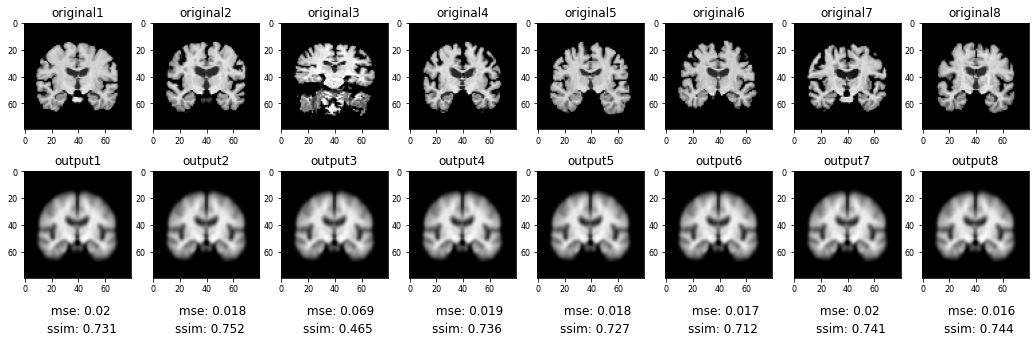

In [19]:
device = torch.device("cuda:1" if torch.cuda.is_available() and True else "cpu")
print("device:", device)    

train_loader, val_loader = load_dataloader(args.n_train, args.batch_size)
output_cpu = []

if args.model == "SoftIntroVAE":
    print("SoftIntroVAE")
    log_path = "./logs/" + args.log + "_SoftIntroVAE/"
    os.makedirs(log_path, exist_ok=True)

    net = SoftIntroVAE(12, [[12,1,2],[24,1,2],[32,2,2],[48,2,2]])
    weight_name = 'softintrovae_weight_epoch299.pth'
    net.load_state_dict( torch.load(log_path + weight_name) )
#    net.load_state_dict(torch.load(log_path+'softintrovae_weight_epoch298.pth'), strict=False)
#    val_loader_iter = iter(train_loader)  元はこのcodeになってた..
    val_loader_iter = iter(val_loader)
    image, _ = next(val_loader_iter)
    image = image.to(device)
    net.to(device)
    net.eval()
    with torch.no_grad():
        _, _, _, output = net(image) # ここdataclassなどで分かりやすくしたい
#  {{ mu, logvar, z, x_re }}
    image = image.cpu()
    
    for out in output:
        output_cpu.append(out.cpu())

    show_image(image, output_cpu)


elif args.model == "VAE":
    print("VAE")
    log_path = "./logs/" + args.log + "_vae/"

    os.makedirs(log_path, exist_ok=True)
    net = models.Vae()
    net.load_state_dict(torch.load(log_path+'vae_weight.pth'))
    val_loader_iter = iter(val_loader)
    image, _ = next(val_loader_iter)
    image = image.to(device)
    net.to(device)
    net.eval()
    with torch.no_grad():
        output, _, _ = net.forward(image)

    image = image.cpu()
    output = output.cpu()
    show_image(image, output)
    mse, ssim = calc_ssim(image, output)
    print(mse, ssim)
    # pil_img = Image.fromarray(np.flip(output[0].numpy().reshape(80, 80, 80).transpose(1,2,0)[50],0) * 255)
    # pil_img = pil_img.convert("L")
    #pil_img.save(log_path+"img/vae_output_img.jpg")


elif args.model == "CAE":
    print("CAE")
    log_path = "./logs/" + args.log + "_cae/"
    os.makedirs(log_path, exist_ok=True)
    net = models.Cae()
    net.load_state_dict(torch.load(log_path+'cae_weight.pth'))
    val_loader_iter = iter(val_loader)
#    val_loader_iter = iter(train_loader)
    image, _ = next(val_loader_iter)
    image = image.to(device)
    net.to(device)
    net.eval()
    with torch.no_grad():
        output = net(image)

    image = image.cpu()
    output = output.cpu()
    show_image(image, output)
    
    
elif args.model == "ResNetVAE":
    print("ResNetVAE")
    log_path = "./logs/" + args.log + "_ResNetVAE/"
    os.makedirs(log_path, exist_ok=True)
    net = models.ResNetVAE(12, [[12,1,2],[24,1,2],[32,2,2],[48,2,2]])
    net.load_state_dict(torch.load(log_path+'resnetvae_weight.pth'))
    val_loader_iter = iter(val_loader)
    image, _ = next(val_loader_iter)
    image = image.to(device)
    net.to(device)
    net.eval()
    with torch.no_grad():
        output, _, _ = net(image)

    image = image.cpu()
    output = output.cpu()
    show_image(image, output)

In [20]:
output[8]

tensor([[[[0.0160, 0.0000, 0.0021,  ..., 0.0075, 0.0000, 0.0085],
          [0.0006, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0070, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0018, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0052, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0012],
          [0.0269, 0.0000, 0.0067,  ..., 0.0016, 0.0000, 0.0264]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0158, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

In [37]:
output[1]

tensor([[[[0.0160, 0.0000, 0.0022,  ..., 0.0075, 0.0000, 0.0085],
          [0.0005, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0070, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0018, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0052, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0013],
          [0.0269, 0.0000, 0.0067,  ..., 0.0016, 0.0000, 0.0264]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0158, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

In [ ]:
encoder_output_list = []
label_list = []

net.to(device)
net.eval()
train_loader_iter = iter(train_loader)

for image, label in train_loader_iter:
    image = image.to(device)
    
    with torch.no_grad():
        encoder_output = net.encoder(image)
    encoder_output = encoder_output.cpu()
    label = label.cpu()
    encoder_output_list.append(encoder_output)
    label_list.append(label)

print(len(encoder_output_list))
print(len(label_list))

In [19]:

import pickle
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

X_embedded_list = []
color_list = []

#t-SNEで次元削減
tsne = TSNE(n_components=2, random_state = 0, perplexity = 30, n_iter = 1000)
for idx in range(len(train_loader)):
    X_embedded = tsne.fit_transform(encoder_output_list[idx])
    X_embedded_list.append(X_embedded)
    print(idx)

NameError: name 'encoder_output_list' is not defined

In [ ]:
X_embeddeds = np.concatenate(X_embedded_list)
labels = np.concatenate(label_list)
#print(X_embeddeds[labels==0])
#print(labels)
plt.figure(figsize = (10, 10))

plt.scatter(X_embeddeds[labels==0, 0], X_embeddeds[labels==0, 1], c="r", label="CN")
plt.scatter(X_embeddeds[labels==1, 0], X_embeddeds[labels==1, 1], c="g", label="AD")
plt.grid()
plt.legend(fontsize=15)